In [5]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
import ast
import matplotlib.pyplot as plt
from geopy.distance import geodesic

def closest_distance(polygon, point_coords):
    closest_distance = float('inf')
    for vertex in polygon.exterior.coords:
        distance = geodesic(point_coords, vertex).meters
        if distance < closest_distance:
            closest_distance = distance
    return closest_distance

def closest_distance_multi(multi_polygon, point_coords):
    closest_distance = float('inf')
    for polygon in multi_polygon:
        for vertex in polygon.exterior.coords:  
            distance = geodesic(point_coords, vertex).meters
            if distance < closest_distance:
                closest_distance = distance
    return closest_distance

def rotate_polygon(polygon):
    if isinstance(polygon, Polygon):
        return Polygon([(point[1], point[0]) for point in polygon.exterior.coords])
    elif isinstance(polygon, MultiPolygon):
        return MultiPolygon([Polygon([(point[1], point[0]) for point in part.exterior.coords]) for part in polygon])
    else:
        return polygon

pd.options.display.float_format = '{:.7f}'.format

In [6]:
df = pd.read_csv("data.csv")
df['Mahalle/Köy'] = df['Mahalle/Köy'].replace('YENİALLE', 'YENİ MAHALLE')
df['Mahalle/Köy'] = df['Mahalle/Köy'].replace('KUTKÖY', 'KURTKÖY')
df['Mahalle/Köy'] = df['Mahalle/Köy'].replace('YUNUSEMRE', 'YUNUS EMRE')
df['Mahalle/Köy'] = df['Mahalle/Köy'].replace('MEHMET AKİF', 'MEHMET AKİF ERSOY')
df['Mahalle/Köy'] = df['Mahalle/Köy'].replace('ESENYURT KOZA', 'KOZA')
df.loc[(df['İlçe'] == "ESENYURT") & (df['Mahalle/Köy'] == "ORHANGAZİ"), 'Mahalle/Köy'] = "ORHAN GAZİ"

df_outers = pd.read_csv('mahalle_sınır_cords.csv')
df_outers.rename(columns = {'AD':'Mahalle/Köy', 'ILCEAD': 'İlçe'}, inplace = True)

df_outers['İl'] = 'İSTANBUL'
df_outers= df_outers[['İl', 'İlçe', 'Mahalle/Köy', 'coords']]
merged = pd.merge(df, df_outers, on=['İl', 'İlçe', 'Mahalle/Köy'], how='left')

gdf = gpd.read_file('mahalle_shapely.json')

In [26]:
for index, row in merged.iterrows():
    #if type(row["Enlem"]) == float and type(row['Boylam']) == float:
       # merged.loc[index, "Koordinat"] = True
        if type(row["coords"]) == str:
            try:
                point = Point(float(row["Enlem"]), float(row["Boylam"]))
            except:
                merged.loc[index, "İÇERDE"] = 2
                continue

            if ((pd.isnull(row['Enlem'])) or (pd.isnull(row['Boylam'])) or (not isinstance(row['Enlem'], (float))) or (not isinstance(float(row['Boylam']), (float))) or (float(row['Enlem']) > 43) or (float(row['Boylam']) > 46)):
                merged.loc[index, "İÇERDE"] = 2
                continue

            outer = ast.literal_eval(row["coords"])
            point_coords = (row['Enlem'], row['Boylam'])
            if len(outer) < 6:
                polygon = MultiPolygon([Polygon(sub_coords) for sub_coords in outer])

                if point.within(polygon) == True:
                    merged.loc[index, "İÇERDE"] = 1
                    merged.loc[index, 'MESAFE'] = closest_distance_multi(polygon, point_coords)

                elif point.within(polygon) == False:
                    merged.loc[index, "İÇERDE"] = 0
                    merged.loc[index, 'MESAFE'] = closest_distance_multi(polygon, point_coords)

                else:
                    raise('İÇERDE sütununu yazarken bir hata oluştu.')

            else:
                polygon = Polygon(outer)

                if point.within(polygon) == True:
                    merged.loc[index, "İÇERDE"] = 1
                    merged.loc[index, 'MESAFE'] = closest_distance(polygon, point_coords)

                elif point.within(polygon) == False:
                    merged.loc[index, "İÇERDE"] = 0
                    merged.loc[index, 'MESAFE'] = closest_distance(polygon, point_coords)

                else:
                    raise('İÇERDE sütununu yazarken bir hata oluştu.')
            
        else:
            print(f'{row["İl"]}, {row["İlçe"]}, {row["Mahalle/Köy"]}, adresinde sınır verisi yok.')
            merged.loc[index, "İÇERDE"] = 3
        
        if index % 15 == 0:
            merged.to_csv("data_updated.csv", index=False)
   # elif:
    #    merged.loc[index, "Koordinat"] = False
     #   print(f"{index}. satırda koordinat yok veya hatalı.")
      #  merged.loc[index, "İÇERDE"] = False
merged.to_csv("data_updated.csv", index=False)

İSTANBUL, PENDİK, YENİ MAHALLE, adresinde sınır verisi yok.
İSTANBUL, PENDİK, YENİ MAHALLE, adresinde sınır verisi yok.
İSTANBUL, PENDİK, YENİ MAHALLE, adresinde sınır verisi yok.


<ipython-input-24-3d7175593485>:18: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in multi_polygon:


İSTANBUL, PENDİK, DOLAYOBA, adresinde sınır verisi yok.
İSTANBUL, PENDİK, YENİ MAHALLE, adresinde sınır verisi yok.
İSTANBUL, PENDİK, YENİ MAHALLE, adresinde sınır verisi yok.
İSTANBUL, PENDİK, YENİ MAHALLE, adresinde sınır verisi yok.
İSTANBUL, PENDİK, DOLAYOBA, adresinde sınır verisi yok.
İSTANBUL, PENDİK, YENİ MAHALLE, adresinde sınır verisi yok.
İSTANBUL, PENDİK, YENİ MAHALLE, adresinde sınır verisi yok.
İSTANBUL, PENDİK, DOLAYOBA, adresinde sınır verisi yok.
İSTANBUL, PENDİK, YENİ MAHALLE, adresinde sınır verisi yok.
İSTANBUL, PENDİK, YENİ MAHALLE, adresinde sınır verisi yok.
İSTANBUL, PENDİK, DOLAYOBA, adresinde sınır verisi yok.
İSTANBUL, PENDİK, DOLAYOBA, adresinde sınır verisi yok.
İSTANBUL, PENDİK, DOLAYOBA, adresinde sınır verisi yok.
İSTANBUL, PENDİK, DOLAYOBA, adresinde sınır verisi yok.
İSTANBUL, PENDİK, YENİ MAHALLE, adresinde sınır verisi yok.
İSTANBUL, PENDİK, DOLAYOBA, adresinde sınır verisi yok.
İSTANBUL, PENDİK, YENİ MAHALLE, adresinde sınır verisi yok.
İSTANBUL, PE

In [ ]:
#İÇERDE = 0 İçerde değil
#İÇERDE = 1 İçerde
#İÇERDE = 2 Konut enlem veya boylam bilgisi sorunlu
#İÇERDE = 3 Merge sırasında konut, koordinat sütunuyla eşleşmemiş

In [7]:
merged = pd.read_csv('data_updated.csv')
merged['İÇERDE'] = merged['İÇERDE'].astype(int)

In [8]:
merged['İÇERDE'].value_counts()

İÇERDE
1    9559
2     648
0     282
Name: count, dtype: int64

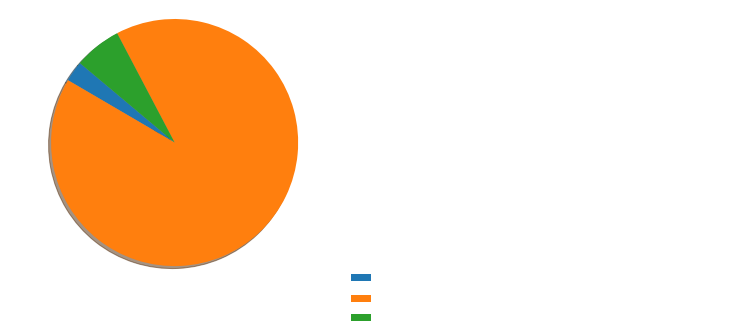

In [9]:
import matplotlib.pyplot as plt

value_labels = {
    0: 'İçerde değil',
    1: 'İçerde',
    2: 'Konut enlem veya boylam bilgisi sorunlu',
    3: 'Merge sırasında konut, mahalle sütunuyla eşleşmemiş' #Merge sırasında konutun mahallesi, mahalle koordinat datasındaki mahalle sütunuyla eşleşmemiş
}

value_counts = merged['İÇERDE'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(6, 5))
wedges, texts, autotexts = ax.pie(
    value_counts,
    autopct='%1.1f%%',
    startangle=140,
    explode=(0.1, 0, 0.1, 0.1),
    shadow=True,
    pctdistance=1.15,
    textprops={'color': 'white', 'fontsize': 14}
)
ax.axis('equal')

legend_labels = [f"{value_labels[value]}: {count} ({value})" for value, count in value_counts.items()]
legend = ax.legend(
    wedges,
    legend_labels,
    title='Verilerin Dağılımı',
    title_fontsize=14,  # Set legend title font size
    loc='lower left',
    bbox_to_anchor=(1.0, -0.2),
    fancybox=True,
    framealpha=0.0
)

# Set legend title text color
legend.get_title().set_color('white')

# Set legend label text color and font size
for text in legend.get_texts():
    text.set_color('white')
    text.set_fontsize(14)

plt.show()


In [10]:
disarda = merged[(merged['MESAFE'] > 0) & (merged['İÇERDE'] == 0)].sort_values(by='MESAFE')
disarda['İÇERDE'] = disarda['İÇERDE'].astype(int)
disarda.drop(columns='coords', inplace=True)

disarda = pd.merge(disarda, gdf, on=['İl', 'İlçe', 'Mahalle/Köy']) # Polygon verileriyle birleştiriyoruz ki bir daha Polygon çizmeyelim.

gdf.to_file('mahalle_shapely.json', driver='GeoJSON')

<ipython-input-1-484ce77d79d4>:29: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return MultiPolygon([Polygon([(point[1], point[0]) for point in part.exterior.coords]) for part in polygon])


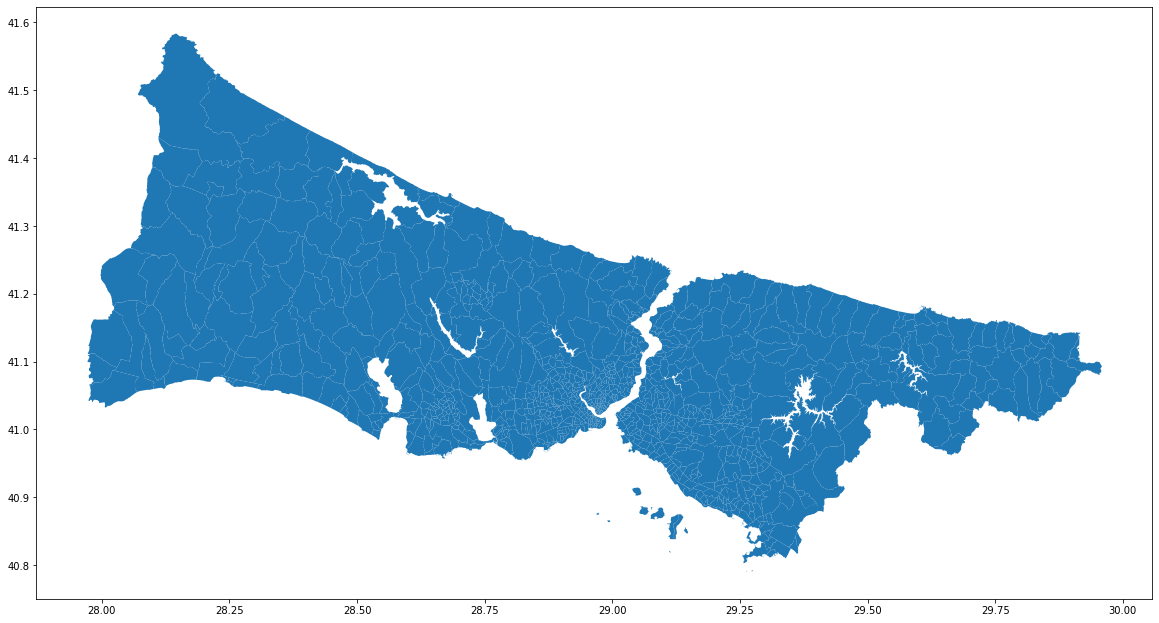

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon

rotated_geometries = gdf['geometry'].apply(rotate_polygon)
rotated_gdf = gpd.GeoDataFrame(gdf.drop(columns=['geometry']), geometry=rotated_geometries)

fig, ax = plt.subplots(figsize=(20, 20))

rotated_gdf.plot(ax=ax)

plt.show()


rotated_disarda.drop(rotated_disarda[rotated_disarda['Gayrimenkul ID/Takip No'] == 8464646].index, inplace=True)

12


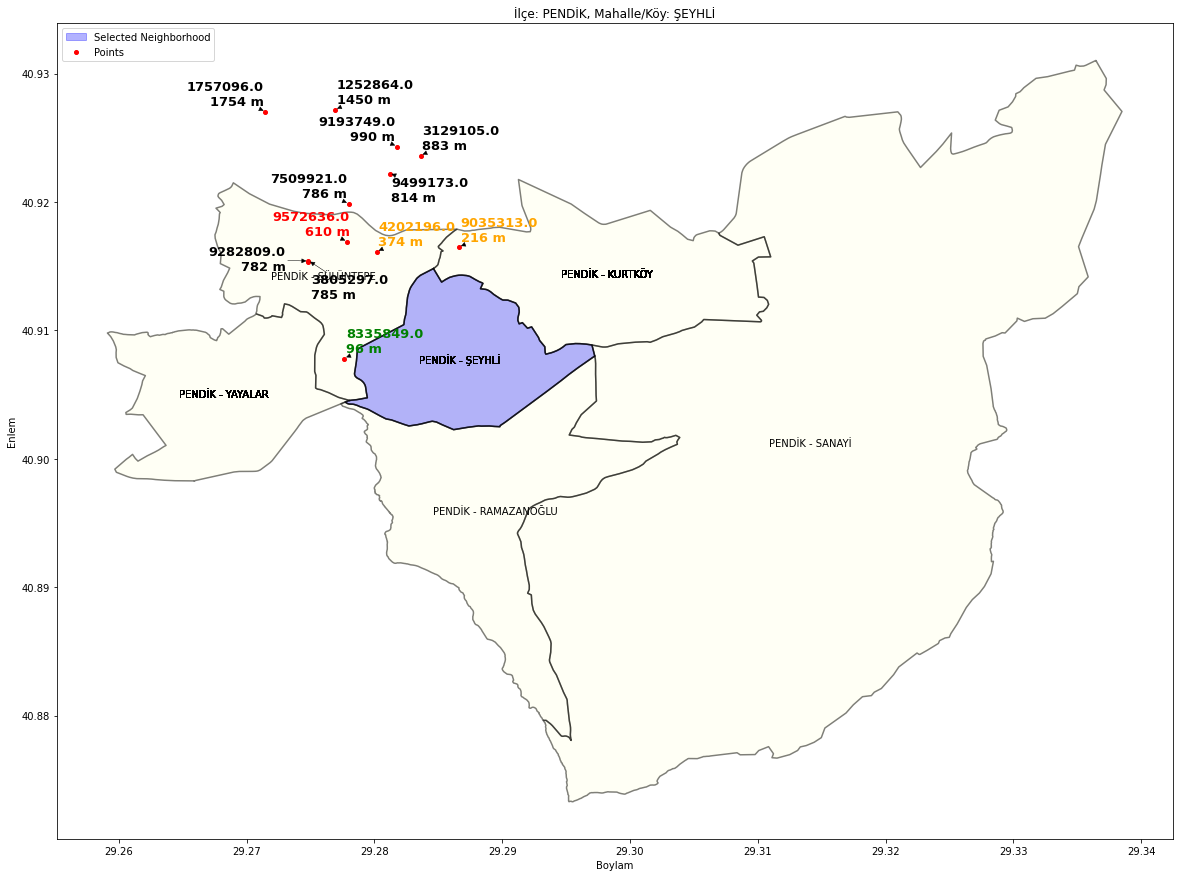

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
from adjustText import adjust_text

gdf = gpd.read_file('mahalle_shapely.json')

rotated_geometries_gdf = gdf['geometry'].apply(rotate_polygon)
gdf_rotated = gpd.GeoDataFrame(gdf.drop(columns=['geometry']), geometry=rotated_geometries_gdf)

rotated_geometries = disarda['geometry'].apply(rotate_polygon)
rotated_disarda = gpd.GeoDataFrame(disarda.drop(columns=['geometry']), geometry=rotated_geometries)
rotated_disarda["Enlem"], rotated_disarda["Boylam"] = pd.to_numeric(rotated_disarda["Enlem"]), pd.to_numeric(rotated_disarda["Boylam"])
merged_geometry = gdf_rotated.merge(rotated_disarda, how='left', on=["İl", "İlçe", "Mahalle/Köy", "geometry"])

def plot_neighborhood(ilce, mahalle_koy, ):
    selected_neighborhood = merged_geometry[(merged_geometry['İlçe'] == ilce) & (merged_geometry['Mahalle/Köy'] == mahalle_koy)]

    selected_polygon = selected_neighborhood.iloc[0]['geometry']

    touching_polygons = merged_geometry[merged_geometry.touches(selected_polygon) | merged_geometry.intersects(selected_polygon)]

    fig, ax = plt.subplots(figsize=(20, 15))

    # Plot the other polygons in contact/bordering with light yellow fill and black edge
    for geom in touching_polygons['geometry'].unique():
        ax.plot(*geom.exterior.xy, color='black', alpha=0.5)
        ax.fill(*geom.exterior.xy, color='lightyellow', alpha=0.3)

    # Plot the selected polygon with blue fill and black edge
    ax.fill(*selected_polygon.exterior.xy, color='blue', alpha=0.3, label='Selected Neighborhood')
    ax.plot(*selected_polygon.exterior.xy, color='black', alpha=0.5)

    # Plot the points for the selected neighborhood
    ax.plot(selected_neighborhood["Boylam"], selected_neighborhood["Enlem"], 'ro', markersize=4, label='Points')

    # Label each neighborhood with its name
    for idx, row in touching_polygons.iterrows():
        geom = row['geometry']
        label = f"{row['İlçe']} - {row['Mahalle/Köy']}"
        ax.text(geom.centroid.x, geom.centroid.y, label, fontsize=10, ha='center', va='center', color='black')

    # Label each point with additional information
    texts = []
    for index, row in selected_neighborhood.iterrows():
        if row["MESAFE"] > 750:
            text_color = 'black'
            text_meaning = 'Distance > 750 m'
        elif 750 >= row["MESAFE"] > 400:
            text_color = 'red'
            text_meaning = '400 m < Distance ≤ 750 m'
        elif 400 >= row["MESAFE"] > 100:
            text_color = 'orange'
            text_meaning = '100 m < Distance ≤ 400 m'
        elif 100 >= row["MESAFE"] >= 0:
            text_color = 'green'
            text_meaning = '0 m ≤ Distance ≤ 100 m'
        else:
            text_color = 'black'
            text_meaning = 'Unknown'
        texts.append(ax.text(row['Boylam'], row['Enlem'] + 0.00005, f'{row["Gayrimenkul ID/Takip No"]}\n{row["MESAFE"]:.0f} m',
                             fontsize=13, color=text_color, ha='center', va='bottom', fontweight= "bold"))
    print(len(texts))
    # Adjust text positions to prevent overlaps
    if len(texts)!= 1:
        adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-|>', color='black', lw=0.5), force_text=0.5)
        
    title = f'İlçe: {ilce}, Mahalle/Köy: {mahalle_koy}'
    ax.set_title(title)
    ax.set_xlabel('Boylam')
    ax.set_ylabel('Enlem')

    # Show legend
    ax.legend()

    plt.show()


In [13]:
plot_neighborhood(ilce="PENDİK", mahalle_koy="ŞEYHLİ")

,İl,İlçe,Mahalle/Köy,geometry,Gayrimenkul ID/Takip No,Tarih,Blok No,Kat No,Bağımsız Bölüm No,Posta Adresi,...,Mutfak,Banyo,Balkon,Mevcut Kullanım Alanı,Mevcut Kullanım Alanına Esas Değeri,Enlem,Boylam,Enerji Kimlik Sınıfı,İÇERDE,MESAFE
450,İSTANBUL,PENDİK,YAYALAR,"POLYGON ((29.26592 40.89828, 29.26535 40.89828...",9254446.0000000,23-08-2021,A,2,7.0,"Güllü Bağlar Mahallesi, Uzundere Sokak, Okyanu...",...,1.0000000,1.0000000,1.0000000,92.0000000,500000.0000000,40.8952470,29.2723150,C,0.0000000,406.7000000
451,İSTANBUL,PENDİK,YAYALAR,"POLYGON ((29.26592 40.89828, 29.26535 40.89828...",6483237.0000000,02-08-2020,B,6,31.0,ESENLER Mah. YAŞAR DOĞU Cad. B BLOK Apt. No: 5...,...,1.0000000,1.0000000,1.0000000,70.0000000,420000.0000000,40.8935000,29.2695000,Y,0.0000000,544.9500000
452,İSTANBUL,PENDİK,YAYALAR,"POLYGON ((29.26592 40.89828, 29.26535 40.89828...",2056497.0000000,23-12-2021,A,2,48.0,"Esenler Mahallesi, Yaşar Doğu Caddesi, Ondörtü...",...,1.0000000,1.0000000,NaN,51.0000000,735000.0000000,40.8933880,29.2695020,C,0.0000000,555.9300000
453,İSTANBUL,PENDİK,YAYALAR,"POLYGON ((29.26592 40.89828, 29.26535 40.89828...",8227941.0000000,10-12-2021,B,9,92.0,GÜLLÜ BAĞLAR mah. TAŞ OCAĞI sok.No: 11 B Daire...,...,1.0000000,2.0000000,1.0000000,110.0000000,1200000.0000000,40.8980450,29.2783130,B,0.0000000,608.8900000
454,İSTANBUL,PENDİK,YAYALAR,"POLYGON ((29.26592 40.89828, 29.26535 40.89828...",7301743.0000000,13-07-2021,B,6,62.0,GÜLLÜ BAĞLAR mah. TAŞ OCAĞI sok.No: 11 B Daire...,...,1.0000000,2.0000000,1.0000000,106.0000000,750000.0000000,40.8980190,29.2785030,NaN,0.0000000,622.2400000
455,İSTANBUL,PENDİK,YAYALAR,"POLYGON ((29.26592 40.89828, 29.26535 40.89828...",2859370.0000000,13-02-2020,-,5,58.0,GÜLLÜ BAĞLAR Mah. TİMUÇİN Sok. ATLANTİK FLY Si...,...,1.0000000,1.0000000,1.0000000,85.0000000,325404.0000000,40.8911390,29.2760860,Y,0.0000000,943.8000000
456,İSTANBUL,PENDİK,YAYALAR,"POLYGON ((29.26592 40.89828, 29.26535 40.89828...",1205358.0000000,20-03-2020,NaN,1,1.0,GÜLLÜ BAĞLAR Mah. YAYLA Sok. No: 80 / 1 PENDİ...,...,1.0000000,1.0000000,1.0000000,65.0000000,250000.0000000,40.8912690,29.2776150,Y,0.0000000,1021.0600000
457,İSTANBUL,PENDİK,YAYALAR,"POLYGON ((29.26592 40.89828, 29.26535 40.89828...",4052415.0000000,26-07-2020,NaN,Z,2.0,"Esenler Mahallesi, Hısım Sokak, No: 8 / 2 Pend...",...,1.0000000,1.0000000,1.0000000,81.0000000,320000.0000000,40.8875000,29.2704000,C,0.0000000,1150.2600000
458,İSTANBUL,PENDİK,YAYALAR,"POLYGON ((29.26592 40.89828, 29.26535 40.89828...",4941276.0000000,22-06-2020,A,3,20.0,KAVAKPINAR Mah. YENİ ASIR Cad. No: 86 A / 20 M...,...,1.0000000,1.0000000,1.0000000,88.0000000,370000.0000000,40.8879500,29.2766030,Y,0.0000000,1247.6700000
459,İSTANBUL,PENDİK,YAYALAR,"POLYGON ((29.26592 40.89828, 29.26535 40.89828...",2078165.0000000,23-07-2020,NaN,Z,3.0,"ESENLER Mah., SANCAK Sok., HUZUR Apt., No: 4, ...",...,1.0000000,1.0000000,NaN,83.0000000,240000.0000000,40.8844000,29.2731000,T,0.0000000,1481.7900000


In [14]:
merged_geometry[(merged_geometry['Mahalle/Köy'] == "YAYALAR") & (merged_geometry['İlçe'] == "PENDİK")]

In [651]:
row_index_to_modify = merged_geometry[merged_geometry['Gayrimenkul ID/Takip No'] == 6897904].iloc[0].name
columns_to_keep = ['İl', 'İlçe', 'Mahalle/Köy', 'geometry']
merged_geometry.loc[row_index_to_modify, merged_geometry.columns.difference(columns_to_keep)] = None